In [1]:
%matplotlib inline
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt, colors as mcolors
import os
import shutil
import numpy as np
from scipy import signal

COLORS = [color[0] for color in list(mcolors.TABLEAU_COLORS.items())]

In [2]:
def plott(dfs, columns, labels=None, x='Epoch', smooth=True, kind='line', agg=None): # 'Epoch' Number of env steps total
    assert kind in ['line', 'bar']
    if labels is not None:
        assert len(dfs) == len(labels)
        
    if type(agg) is not list:
        agg = [agg] * len(dfs)

    if len(columns) > 2:
        fig, axs = plt.subplots(2,2)
        fig.set_figheight(10)
        fig.set_figwidth(15)
    else:
        fig, axs = plt.subplots(1,2)
        fig.set_figheight(5)
        fig.set_figwidth(15)

    for i, column in enumerate(columns):    
        for j, df in enumerate(dfs):
            if column not in df.columns:
                continue
            if len(columns) > 2:
                axspos = axs[int(i/2), int(i%2)]
            else:
                axspos = axs[i]

            axspos.set_axisbelow(True)
            axspos.grid(color='gray', linestyle='dashed')
            axspos.grid(color='gray', linestyle='dashed')
            axspos.locator_params(axis='y', nbins=18)

            if kind == 'line':
                apply_smooth = smooth and len(df[x]) > 100
                if apply_smooth:
                    axspos.plot(df[x], signal.savgol_filter(df[column], 51, 11), figure=fig, color=COLORS[j % len(COLORS)], label=labels[j])
                axspos.plot(df[x], df[column], figure=fig, alpha=0.2 if apply_smooth else 1, color=COLORS[j % len(COLORS)], label=None if apply_smooth else labels[j])
            else:
                axspos.bar(j, df[x].mean() if agg[i] is None or agg[i] == 'mean' else df[x].max() / 3600, figure=fig, color=COLORS[j % len(COLORS)], label=labels[j])
            axspos.legend(loc='upper right')
            axspos.set_title(column)

In [3]:
REMOVE_BELOW_STEPS = 100000
progresses = []

for dirname, _, filenames in os.walk('output'):
    for filename in filenames:
        if 'progress' in filename:
            file = os.path.join(dirname, filename)

            try:
                tempdf = pd.read_csv(file)
            except pd.errors.EmptyDataError as e:
                #shutil.rmtree(dirname, ignore_errors=True)
                print('Removed empty folder', dirname)
                continue

            steps = tempdf['Number of env steps total'].iloc[-1]
            if steps < REMOVE_BELOW_STEPS or 'ipynb' in dirname:
                shutil.rmtree(dirname, ignore_errors=True)
                print('Removed experiment (', steps, ' steps)', dirname)
                continue
                
            progresses.append(file)

progresses.sort()
for i, progress in enumerate(progresses):
    print(i, progress)

0 output/reach-ml1/2020_07_02_18_38_47/progress.csv
1 output/reach-ml1/2020_07_05_17_54_38/progress.csv


In [8]:
results = [
    #('Int Obs', pd.read_csv("output/cheetah-vel/2020_02_16_00_49_55-intobs/progress.csv", skiprows=[1])),
    #('Int Ctx', pd.read_csv("output/cheetah-vel/2020_02_17_18_09_55-intctx/progress.csv", skiprows=[1])),
    #('PEARL', pd.read_csv("output/cheetah-vel/2020_03_03_16_20_26-baseline/progress.csv", skiprows=[1], nrows=100)),
    #('PEARL', pd.read_csv("output/cheetah-vel/2020_03_04_17_23_41-baseline/progress.csv", skiprows=[1])),
    #('Int Ctx', pd.read_csv("output/cheetah-vel/2020_03_05_23_41_01-intctx/progress.csv", skiprows=[1])),
    #('Ctx Only Grads', pd.read_csv("output/cheetah-vel/2020_03_06_13_23_33-ctxgrads/progress.csv", skiprows=[1])),
    #('Int Ctx 3', pd.read_csv("output/cheetah-vel/2020_03_07_23_12_39-intctx/progress.csv", skiprows=[1])),
    #('Int Ctx 4', pd.read_csv("output/cheetah-vel/2020_03_17_00_33_59-intctx/progress.csv", skiprows=[1])),
    #('L2 0.1', pd.read_csv("output/cheetah-vel/2020_03_26_04_30_37-l2-01/progress.csv", skiprows=[1])),
    #('Dropout', pd.read_csv("output/cheetah-vel/2020_03_26_04_34_42-dropout/progress.csv", skiprows=[1])),
    #('L2 0.01', pd.read_csv("output/cheetah-vel/2020_03_27_00_51_58-l2/progress.csv", skiprows=[1])),

    #('Int Obs', pd.read_csv('output/humanoid-dir/2020_02_05_00_35_33-intobs/progress.csv', skiprows=[1], nrows=100)),

    #('Int Obs', pd.read_csv('output/pick-place-ml1/2020_02_13_22_39_42-intobs/progress.csv', skiprows=[1])),
    #('PEARL', pd.read_csv('output/pick-place-ml1/2020_02_15_02_00_11-baseline/progress.csv', skiprows=[1])),
    #('Int Obs', pd.read_csv('output/pick-place-ml1/2020_02_15_02_02_24/progress.csv', skiprows=[1])),
    #('Int Obs', pd.read_csv('output/pick-place-ml1/2020_03_04_01_00_28/progress.csv', skiprows=[1])),

    #('PEARL 3 Adapt', pd.read_csv('output/reach-ml1/2020_04_09_01_49_41-baseline-3adapt/progress.csv', skiprows=[1])),
    #('PEARL', pd.read_csv('output/reach-ml1/2020_04_15_22_29_42-baseline/progress.csv', skiprows=[1])),
    #('PEARL OOD', pd.read_csv('output/reach-ml1/2020_04_18_23_23_57-baseline-ood/progress.csv', skiprows=[1])),
    #('PEARL Scale', pd.read_csv('output/reach-ml1/2020_04_18_23_25_34-rwscale/progress.csv', skiprows=[1])),
    #('L2 0.01 OOD', pd.read_csv('output/reach-ml1/2020_04_21_15_12_49-l2-ood/progress.csv', skiprows=[1])),
    #('Int Obs OOD', pd.read_csv('output/reach-ml1/2020_04_21_15_13_40-intobs-ood/progress.csv', skiprows=[1])),
    #('Int Ctx OOD', pd.read_csv('output/reach-ml1/2020_04_23_11_14_21-intctx-ood/progress.csv', skiprows=[1])),
    #('Int Ctx', pd.read_csv('output/reach-ml1/2020_04_23_13_48_31-intctx/progress.csv', skiprows=[1])),
    #('L2 0.01', pd.read_csv('output/reach-ml1/2020_04_25_13_48_34-l2/progress.csv', skiprows=[1])),
    #('L2 0.01 OOD', pd.read_csv('output/reach-ml1/2020_04_27_14_07_46-l2-ood/progress.csv', skiprows=[1])),
    #('L2 0.01', pd.read_csv('output/reach-ml1/2020_04_30_10_47_22-l2/progress.csv', skiprows=[1])),
    #('PEARL', pd.read_csv('output/reach-ml1/2020_05_15_12_07_44-baseline/progress.csv', skiprows=[1])),
    #('L2 0.01', pd.read_csv('output/reach-ml1/2020_05_15_12_08_37-l2/progress.csv', skiprows=[1])),
    #('Latent 15', pd.read_csv('output/reach-ml1/2020_05_15_12_09_16-latent15/progress.csv', skiprows=[1])),
    #('PEARL', pd.read_csv('output/reach-ml1/2020_05_21_12_06_15-baselinelong/progress.csv', skiprows=[1])),
    #('L2', pd.read_csv('output/reach-ml1/2020_05_21_12_07_10-l2long/progress.csv', skiprows=[1])),
    #('PEARL Next Obs Ctx', pd.read_csv('output/reach-ml1/2020_05_29_15_17_09-baselinenextobs/progress.csv', skiprows=[1])),
    #('PEARL Next Obs Ctx Latent 3', pd.read_csv('output/reach-ml1/2020_05_29_15_22_28/progress.csv', skiprows=[1])),
    #('PEARL OOD', pd.read_csv('output/reach-ml1/2020_05_31_17_31_11-pearl-ood/progress.csv', skiprows=[1])),
    #'L2 OOD', pd.read_csv('output/reach-ml1/2020_05_31_17_31_40-l2-ood/progress.csv', skiprows=[1])),
    ('PEARL OOD', pd.read_csv('output/reach-ml1/2020_07_02_18_38_47/progress.csv', skiprows=[1], nrows=250)),
    ('L2 OOD', pd.read_csv('output/reach-ml1/2020_07_05_17_54_38/progress.csv', skiprows=[1], nrows=250)),
    

    #('Int Ctx', pd.read_csv('output/sparse-point-robot/2020_02_06_00_14_15-intctx/progress.csv', skiprows=[1])),
    #('PEARL', pd.read_csv('output/sparse-point-robot/2020_02_07_01_13_52-baseline/progress.csv', skiprows=[1])),
    
    #('Int Ctx', pd.read_csv('output/walker-rand-params/2020_02_07_23_05_18-intctx/progress.csv', skiprows=[1])),
]

for i, (label, df) in enumerate(results):
    if label == 'PEARL' and 'Mean Intrinsic Reward' in df.columns:
        label = 'Intrinsic'
        results[i] = (label, df)

    print('Results {} ({}): {} steps ({} epochs) in {:.2f} hours'.format(
        i,
        label,
        df['Number of env steps total'].iloc[-1],  
        df['Epoch'].iloc[-1],
        float(df['Total Train Time (s)'].iloc[-1] / 60 / 60)
    ))
    
    print('Train Time: {} | Sample Time: {} | Epoch Time: {} | Previous Eval Time: {}'.format(
        df['Train Time (s)'].iloc[-1],
        df['Sample Time (s)'].iloc[-1],
        df['Epoch Time (s)'].iloc[-1],
        df['(Previous) Eval Time (s)'].iloc[-10],
    ))
    
for column in results[0][1].columns:
    pass
    #print(column)

Results 0 (PEARL OOD): 9517500 steps (2509 epochs) in 69.80 hours
Train Time: 41.11139222397468 | Sample Time: 8.770214757882059 | Epoch Time: 49.88322820386384 | Previous Eval Time: 0.001343279960565269
Results 1 (L2 OOD): 8842500 steps (2329 epochs) in 63.07 hours
Train Time: 42.40525199100375 | Sample Time: 7.724223379977047 | Epoch Time: 50.13049246498849 | Previous Eval Time: 0.0006326339207589626


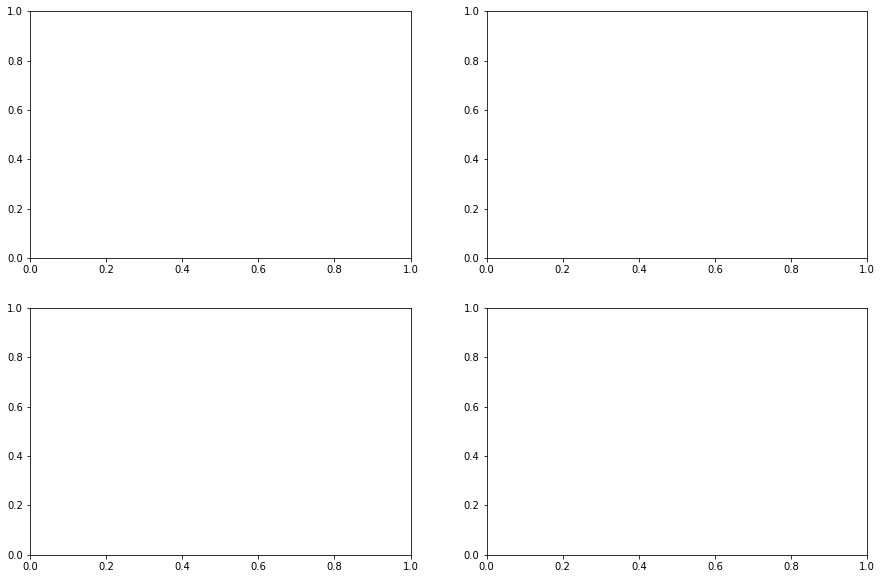

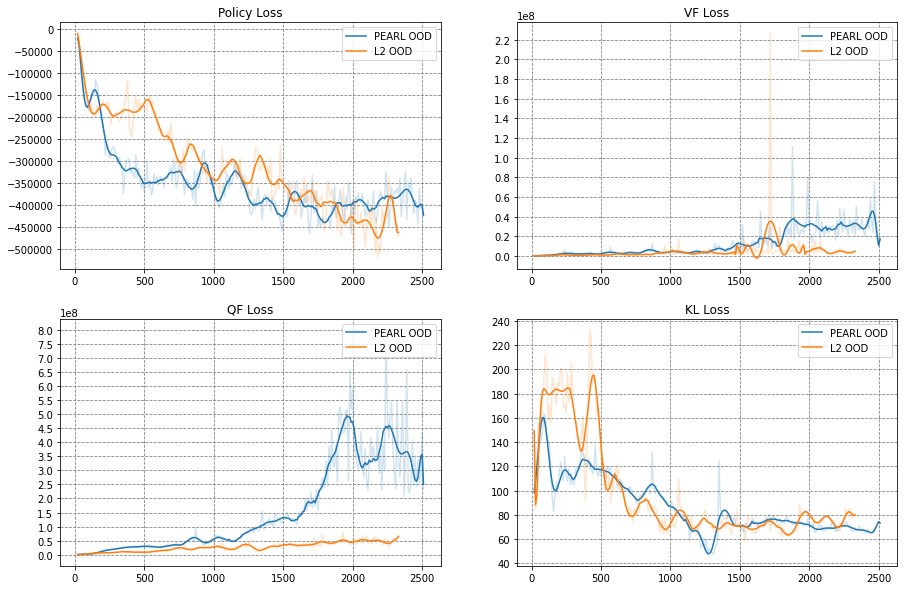

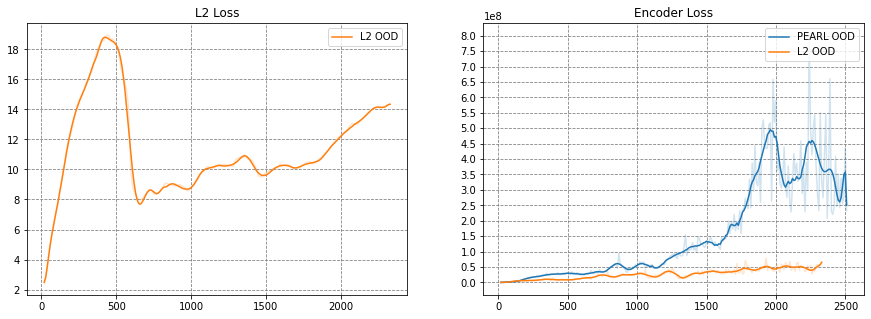

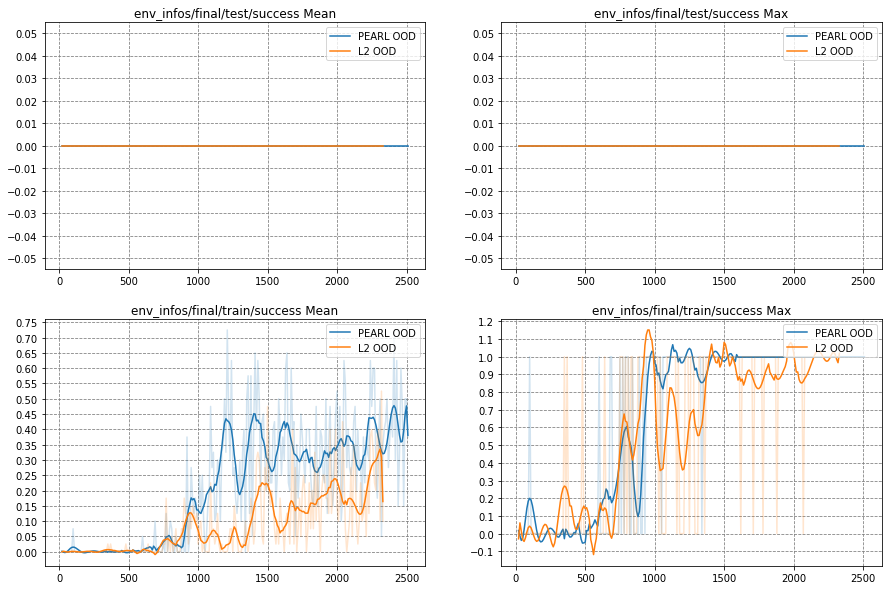

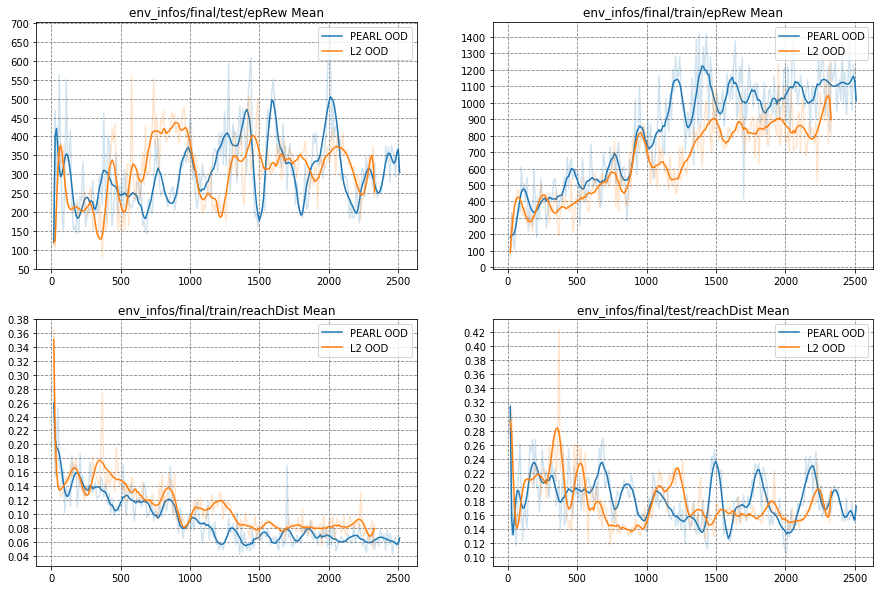

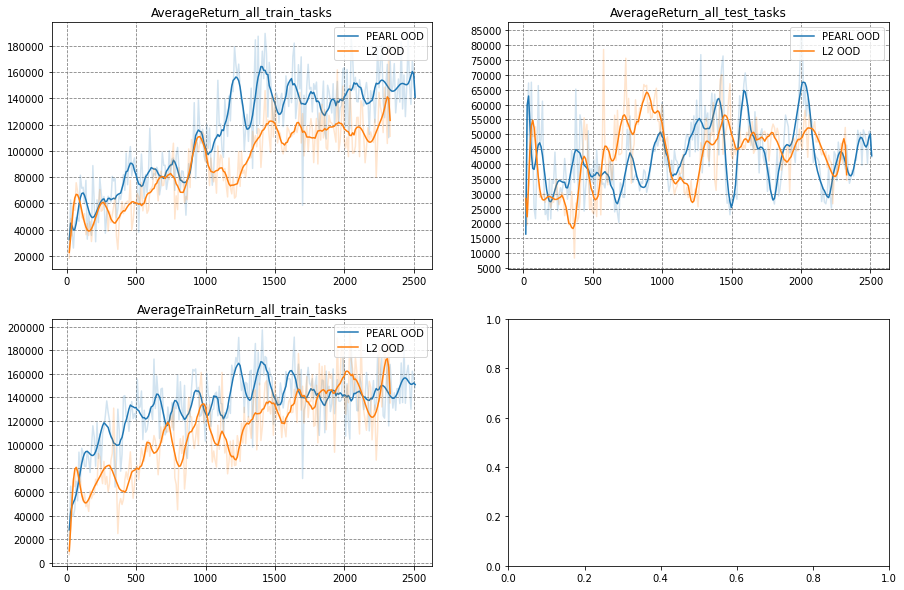

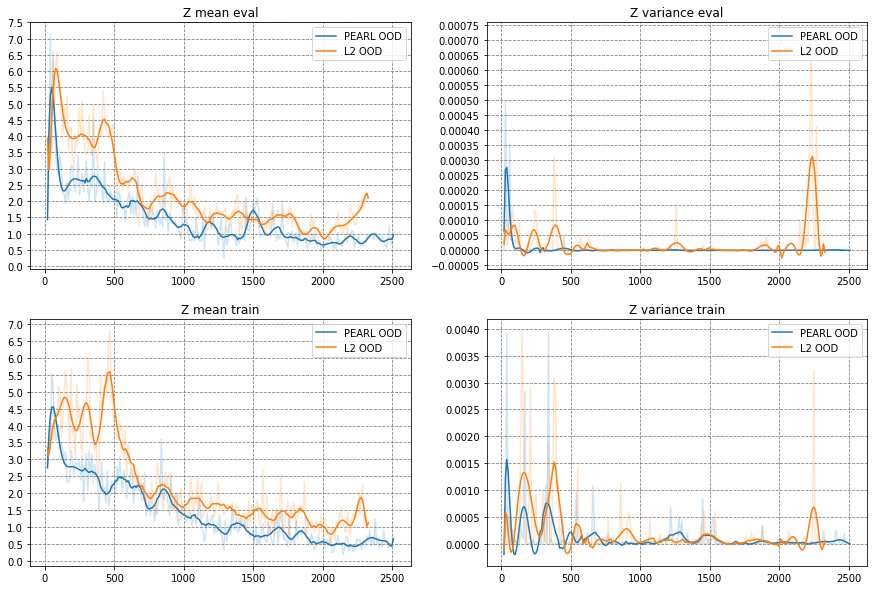

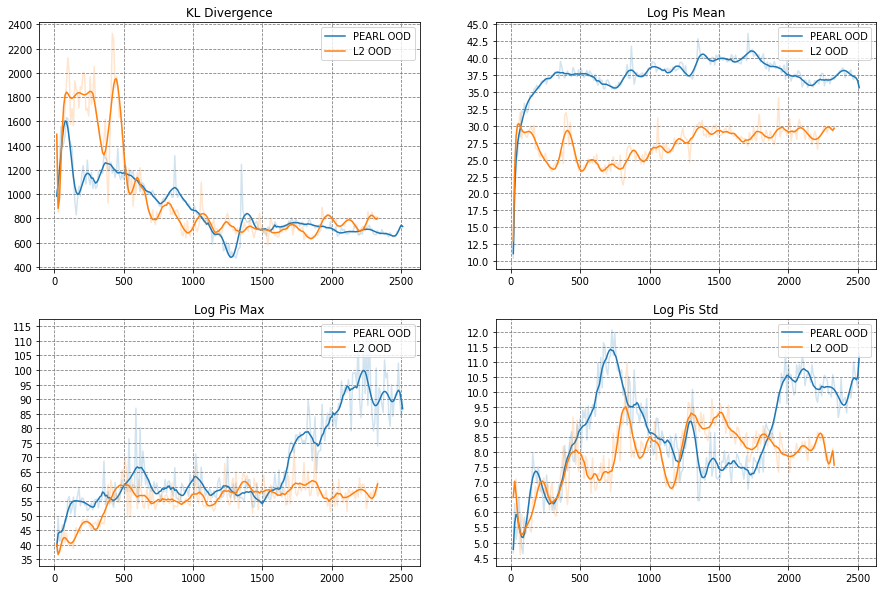

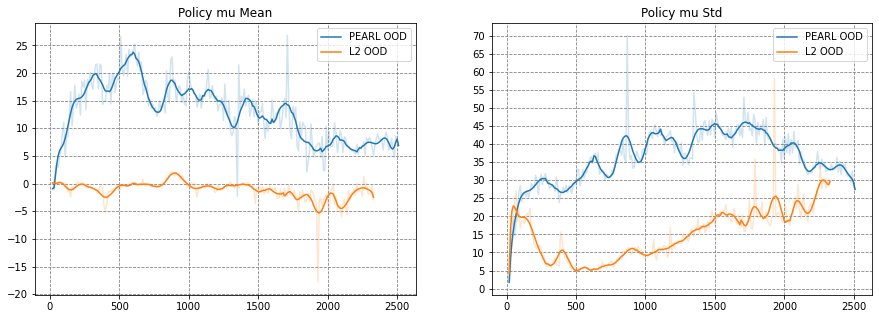

In [9]:
dfs = [df for _, df in results]
labels = [label for label, _ in results]
#plott(dfs, ['Total Train Time (s)', 'Train Time (s)', 'Sample Time (s)', 'Epoch Time (s)'], labels, kind='bar', agg=['max', 'mean', 'mean', 'mean'])
plott(dfs, ['Decoder Loss', 'Mean Intrinsic Reward', 'Mean Extrinsic Reward', 'Mean Reward'], labels)
plott(dfs, ['Policy Loss', 'VF Loss', 'QF Loss', 'KL Loss'], labels)
plott(dfs, ['L2 Loss', 'Encoder Loss'], labels)
plott(dfs, ['env_infos/final/test/success Mean', 'env_infos/final/test/success Max', 'env_infos/final/train/success Mean', 'env_infos/final/train/success Max'], labels)
plott(dfs, ['env_infos/final/test/epRew Mean', 'env_infos/final/train/epRew Mean', 'env_infos/final/train/reachDist Mean', 'env_infos/final/test/reachDist Mean'], labels) # 'env_infos/final/test/goalDist Mean', 'env_infos/final/train/goalDist Mean'
plott(dfs, ['AverageReturn_all_train_tasks', 'AverageReturn_all_test_tasks', 'AverageTrainReturn_all_train_tasks'], labels), # 'Mean Extrinsic Reward'
plott(dfs, ['Z mean eval', 'Z variance eval', 'Z mean train', 'Z variance train'], labels)
plott(dfs, ['KL Divergence', 'Log Pis Mean', 'Log Pis Max', 'Log Pis Std'], labels) # 'Latent Entropy'
plott(dfs, ['Policy mu Mean', 'Policy mu Std'], labels)